# Using VesselsService and VesselStatesService to generate custom timeseries

In this example we will use our vessels and vessel states services to generate custom timeseries on vessel locations and vessel statuses. We will filter on custom attributes and group on relevant columns.

## Setup and data fetching

First we setup the imports and fetch the list of vessels we are interested in. We could also use a predefined list of IMOs instead of fetching a list of supramaxes as we do in this example.

In [55]:
from oceanbolt.sdk.client import APIClient
from oceanbolt.sdk.data import VesselStates, Vessels
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt

#Setup the client: either the token needs to be inputted directly in the APIClient() function: ApiClient("TOKEN HERE"), or it needs to available in the env variables as OCEANBOLT_API_KEY
base_client = APIClient()

In [81]:
# Get all ultramax vessels
vsls = Vessels(base_client).get(sub_segment=["ultramax"])
vsls = vsls.head(200) # Here we limit the script to just fetch the first 200 vessels.
vsls

,vessel_name,imo,mmsi,last_position_received,last_static_received,dwt,segment,sub_segment,zone_id,zone_name,...,eta,navigational_status,last_port_name,last_country_code,last_region,port_call_status,commodity_group,commodity_name,direction,speed
0,ABILITY,9908281,0,2022-03-10T01:25:43Z,2022-03-09T23:04:55Z,63800,Supramax,Ultramax (60-68k),58,East Coast South America,...,2022-03-08T08:00:00Z,0,Coronel,CL,WCSA,not_in_port,,,NNE,13.5
1,ACER ARROW,9720043,0,2022-03-10T06:00:46Z,2022-03-10T03:55:35Z,61066,Supramax,Ultramax (60-68k),32,Pacific Ocean (Central America),...,2022-03-14T14:00:00Z,0,Bayuquan,CN,FAREAST,not_in_port,Steel,Steel Products (unclassified),ESE,12.2
2,ACHILLEAS,9575137,0,2022-03-10T05:31:03Z,2022-03-07T11:02:07Z,63301,Supramax,Ultramax (60-68k),5,North Pacific Ocean (Japan),...,2022-01-02T02:30:00Z,0,Kandla,IN,WCINDIA,not_in_port,Salt,Salt (unclassified),NNE,9.9
3,ADAM SCHULTE,9700067,0,2022-03-10T00:43:47Z,2022-03-09T20:39:06Z,63493,Supramax,Ultramax (60-68k),96,West Coast India,...,2022-02-28T00:00:00Z,0,Mangalore,IN,WCINDIA,not_in_port,,,SSE,11.4
4,ADVENTURER,9805752,0,2022-03-10T04:40:38Z,2022-03-10T04:36:07Z,62472,Supramax,Ultramax (60-68k),11,Black Sea,...,2022-03-03T03:30:00Z,5,Constantza (Constanta),RO,BLACKSEA,in_berth,Grains,Grains (unclassified),SSE,0.0


Then we fetch the core vessel states data, which we will use as a basis for our analysis.

Note that this step will take some time depending on the number of vessels fetched. It is suggested to save the results locally (in a separate script) and only refresh this data when needed.

In [82]:
appended_data = []
for imo in vsls["imo"]:
    start_date = date(2018,1,1)
    end_date = date(2022,3,10)

    data = VesselStates(base_client).get(
        start_date=start_date,
        end_date=end_date,
        imo=[imo],
    )
    appended_data.append(data)

    # Print progress
    print("Fetching from:",start_date, " -> ",end_date, " for imo ",imo ,"| Rows: ", len(data))

appended_data = pd.concat(appended_data)
appended_data["timestamp"] = pd.to_datetime(appended_data["timestamp"])
appended_data

Fetching from: 2018-01-01  ->  2022-03-10  for imo  9908281 | Rows:  268
Fetching from: 2018-01-01  ->  2022-03-10  for imo  9720043 | Rows:  1530
Fetching from: 2018-01-01  ->  2022-03-10  for imo  9575137 | Rows:  1530
Fetching from: 2018-01-01  ->  2022-03-10  for imo  9700067 | Rows:  1530
Fetching from: 2018-01-01  ->  2022-03-10  for imo  9805752 | Rows:  1530


,vessel_name,imo,mmsi,timestamp,dwt,segment,sub_segment,vessel_type,zone_id,zone_name,...,commodity_group,commodity_name,direction,speed_status,last_visited_port_id,last_visited_port_name,last_ops_port_id,last_ops_port_name,volume_on_board,hours_carried_forward
0,,9908281,636020794,2021-06-16,63800,Supramax,Ultramax (60-68k),Bulk Carrier,5,North Pacific Ocean (Japan),...,,,NNE,speed_below_2,0,,0,,0,0
1,,9908281,636020794,2021-06-17,63800,Supramax,Ultramax (60-68k),Bulk Carrier,5,North Pacific Ocean (Japan),...,,,NNE,speed_below_2,0,,0,,0,0
2,,9908281,636020794,2021-06-18,63800,Supramax,Ultramax (60-68k),Bulk Carrier,5,North Pacific Ocean (Japan),...,,,NNW,speed_below_2,0,,0,,0,0
3,,9908281,636020794,2021-06-19,63800,Supramax,Ultramax (60-68k),Bulk Carrier,5,North Pacific Ocean (Japan),...,,,SSE,speed_below_2,0,,0,,0,0
4,,9908281,636020794,2021-06-20,63800,Supramax,Ultramax (60-68k),Bulk Carrier,5,North Pacific Ocean (Japan),...,,,ENE,speed_below_2,0,,0,,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,,9805752,405000346,2022-03-06,62472,Supramax,Ultramax (60-68k),Bulk Carrier,11,Black Sea,...,,,SSE,speed_below_2,4761,Karasu,2073,Constantza (Constanta),0,0
1526,,9805752,405000346,2022-03-07,62472,Supramax,Ultramax (60-68k),Bulk Carrier,11,Black Sea,...,,,SSE,speed_below_2,4761,Karasu,2073,Constantza (Constanta),0,0
1527,,9805752,405000346,2022-03-08,62472,Supramax,Ultramax (60-68k),Bulk Carrier,11,Black Sea,...,,,SSE,speed_below_2,4761,Karasu,2073,Constantza (Constanta),0,0
1528,,9805752,405000346,2022-03-09,62472,Supramax,Ultramax (60-68k),Bulk Carrier,11,Black Sea,...,,,SSE,speed_below_2,4761,Karasu,2073,Constantza (Constanta),0,0


# Vessels with speed above two in Atlantic over time

Now we are creating a new column 'basin', which is a flag staging whether the vessel is inside the Atlantic Ocean.
Then we prepare the data for plotting.

<AxesSubplot:title={'center':'All vessels inside/outside atlantic (Supramax)'}, xlabel='timestamp'>

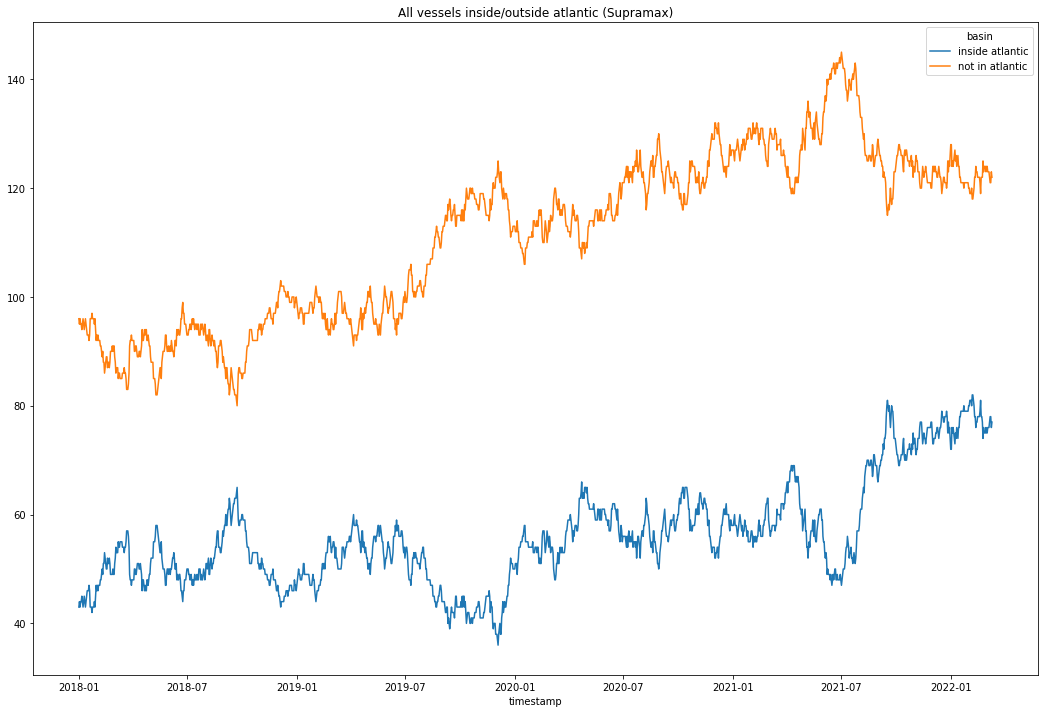

In [77]:
atlantic_zones= [46,11,9,58,18,42,25,59,24,7,15,21] # as extracted from app.oceanbolt.com zone selector
appended_data["basin"] = "not in atlantic"
appended_data.loc[appended_data.zone_id.isin(atlantic_zones), 'basin'] = "inside atlantic"
zone_counts = appended_data.groupby(by=[appended_data.timestamp.dt.date,appended_data.basin]).size().reset_index()
pivoted_zone_counts = zone_counts.pivot(index="timestamp", columns="basin", values=0)
pivoted_zone_counts.plot(figsize=(18, 12),title="All vessels inside/outside atlantic (Supramax)")

## Slow steaming vessels in Atlantic
We filter on the speed status of the vessels to include only vessels with speed between 2 and 8 knots.

<AxesSubplot:title={'center':'Slow steaming vessels inside/outside atlantic (Supramax)'}, xlabel='timestamp'>

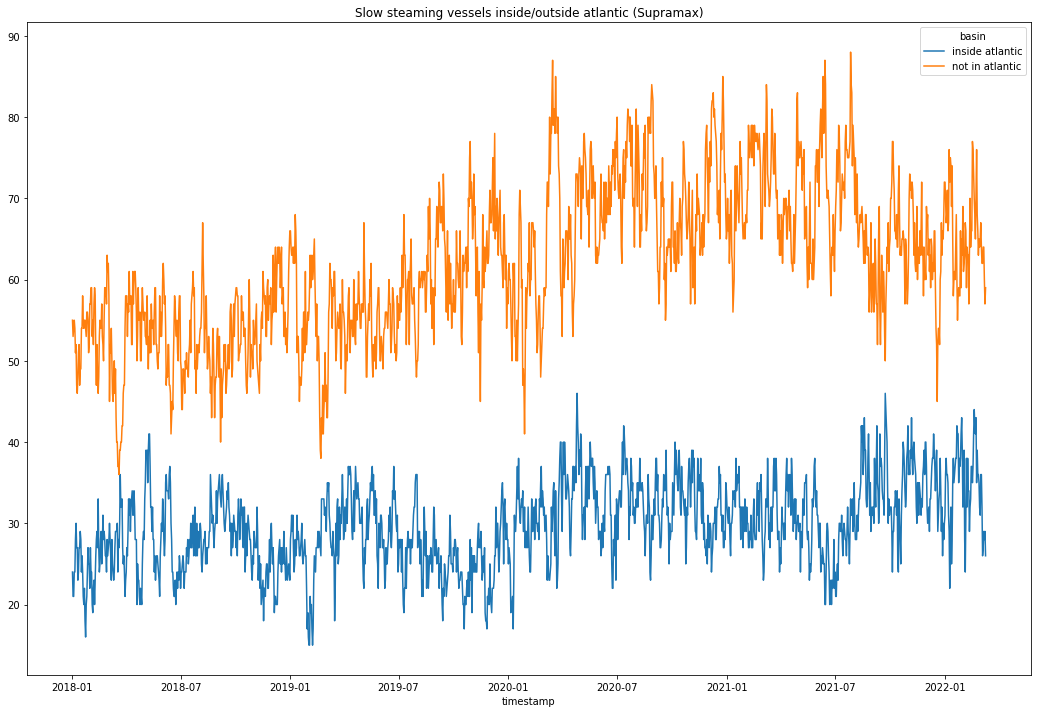

In [78]:
slow_steaming=appended_data[appended_data.speed_status=="speed_between_2_and_8"]
zone_counts = slow_steaming.groupby(by=[slow_steaming.timestamp.dt.date,slow_steaming.basin]).size().reset_index()
pivoted_zone_counts = zone_counts.pivot(index="timestamp", columns="basin", values=0)
pivoted_zone_counts.plot(figsize=(18, 12),title="Slow steaming vessels inside/outside atlantic (Supramax)")

# Vessels by port call status

Another thing we could visualize is the number of vessels in port/berth/shipyard per day

<AxesSubplot:title={'center':'All vessels by port call status'}, xlabel='timestamp'>

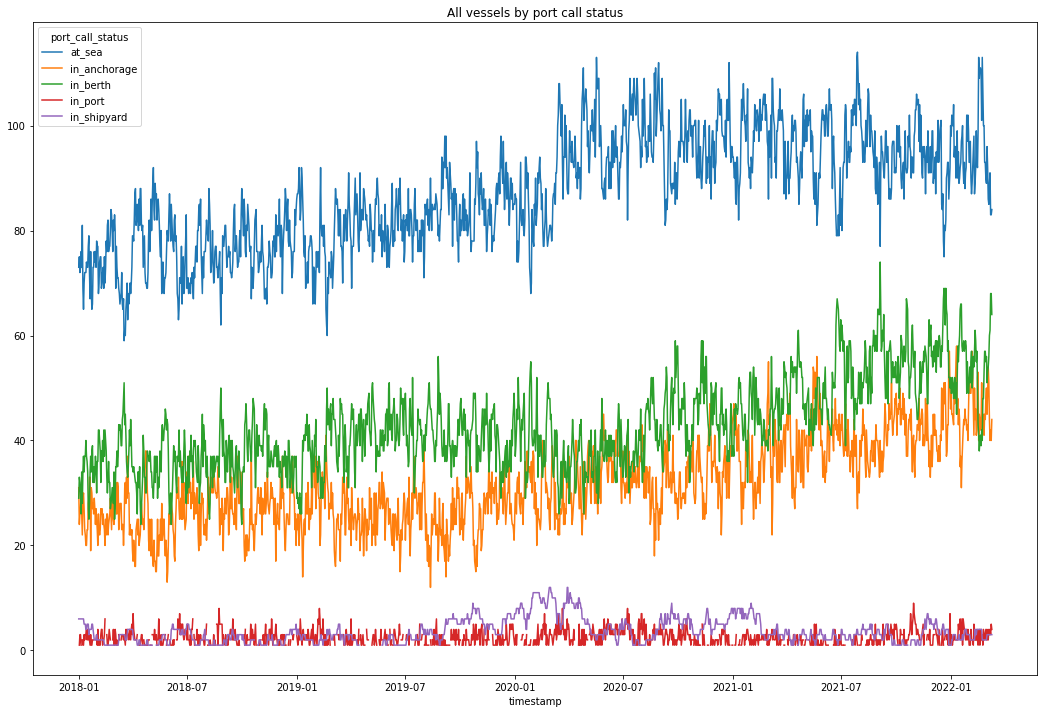

In [79]:
zone_counts = appended_data.groupby(by=[appended_data.timestamp.dt.date,appended_data.port_call_status]).size().reset_index()
pivoted_zone_counts = zone_counts.pivot(index="timestamp", columns="port_call_status", values=0)
pivoted_zone_counts.plot(figsize=(18, 12),title="All vessels by port call status")